You need to have IPTA DR2 data somewhere on your machine.  You can pull it from `gitlab`:
```bash
$ git clone https://gitlab.com/IPTA/DR2
```

In [12]:
import numpy as np
import os, glob
import json
import matplotlib.pyplot as plt
import libstempo as t2
import IPTA_DR2_analysis.utils as dr2u

# 1) Clean par and tim files

1. Make a directory called `partim` that contains a single par file and single tim file for all pulsars.

2. Clean the par files by removing all noise and DM model parameters. We will also add in DM1 and DM2 if not already present in the par file.

3. Concatenate all "INCLUDEs" into a single tim file

This uses `clear_par()` and `combine_tim()` from `dr2lite_utils`

### Create partim directory

In [6]:
project_path = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
DR2DATA = os.path.abspath('/vast/palmer/home.grace/bbl29/DR2/')  # path to data for Docker image
datadir = os.path.join(DR2DATA, 'release/VersionB')
outdir = f'{project_path}/data/partim'

### Clean par files

In [8]:
parfiles = glob.glob(datadir + '/J*/*IPTADR2.par')

psr_names = []
for p in parfiles:
    name = p.split('/')[-2]
    psr_names.append(name)
    outfile = os.path.join(outdir, '{}.par'.format(name))
    dr2u.clean_par(p, outfile)

### Combine tim files

In [9]:
timfiles = glob.glob(datadir + '/J*/*IPTADR2.tim')

for t in timfiles:
    name = t.split('/')[-2]
    outfile = os.path.join(outdir, '{}.tim'.format(name))
    dr2u.combine_tim(t, outfile)

# 2.1) How to create filtered par and tim files

Here we create a filtered dataset by applying a frequency filter and a PTA filter

1. **Frequency filter**: Only keep TOAs that have a certain bandwidth (`bw`) coverage over a certain period of time (`dt`). For instance, `dt=7` and `bw=1.1` will only keep TOAs that have at band ratio of at least 1.1 (i.e. $f_{max} / f_{min} > 1.1$) in every 7 day window.

2. **Flag filter**: Only keep TOAs with a give flag value.  For example keep only TOAs with flag `pta` for a subset of PTAs or flag `group` for a subset of backends.

These steps use the functions provided in `dr2lite_utils`

### Filter dictionary
This is input to `filter_psr()`.  This is a dictionary where the keys are TOA flags and the values are lists of acceptable flagvals to keep.  If a single flagval is to be kept, it my be passed as is (not as a list).

For a given flag (e.g. `pta`), filters are applied as a `logical_or`.  For a TOA to be kept, it must pass all individual filters as a `logical_and`.

**examples:**

 * ```python
fliter_dict = {'pta':'NANOGrav', 'group':['Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']}
```
This would keep only toas from NANOGrav with 800 MHz GUPPI **OR** L-band GUPPI.  Since only NANOGrav uses GUPPI, the `pta` flag is redundant.  Since PTA filters are the most common, we choose to always use a PTA filter for clarity.

 * ```python
fliter_dict = {'pta':['PPTA', 'EPTA']}
```
This would keep all PPTA and EPTA data for the pulsar.

 * ```python
fliter_dict = {'pta':'PPTA', 'group':'Rcvr_1_2_GUPPI}
```
This would keep any PPTA data that uses the L-band GUPPI backend... no TOAs would be returned.

As a further example you can select data for a pulsar of your choice and plot the TOA residuals color coded by backend.  Here we provide a filter for XASP/XUPPI NANOGrav data:

In [10]:
# filter parameters
BW = 1.1
DM_window = 10

filt = {
    'pta':'NANOGrav',
    'group':['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP',
             '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI',  'S-wide_PUPPI',
             'Rcvr_800_GASP', 'Rcvr1_2_GASP',
             'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI',
            ],
}

psrName = 'J1713+0747'

parfile = os.path.join(outdir, '{}.par'.format(psrName))
timfile = os.path.join(outdir, '{}.tim'.format(psrName))
psr = t2.tempopulsar(parfile, timfile, maxobs=30000)

psr = dr2u.filter_psr(psr, bw=BW, dt=DM_window, filter_dict=filt, plot=False)

Working on PSR J1713+0747
Keeping TOAs corresponding to pta NANOGrav
Keeping TOAs corresponding to group ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP', '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI', 'S-wide_PUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI']
Running multi-frequency filter


/tmp/ipykernel_2113132/4151348742.py:20: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  psr = dr2u.filter_psr(psr, bw=BW, dt=DM_window, filter_dict=filt, plot=False)


Cutting 2944 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35', 'JUMP36', 'JUMP37', 'JUMP38', 'JUMP39', 'JUMP40', 'JUMP41', 'JUMP42', 'JUMP43', 'JUMP44', 'JUMP45', 'JUMP46', 'JUMP47', 'JUMP48', 'JUMP49', 'JUMP50', 'JUMP51']


#### TOA plot, colored by backend

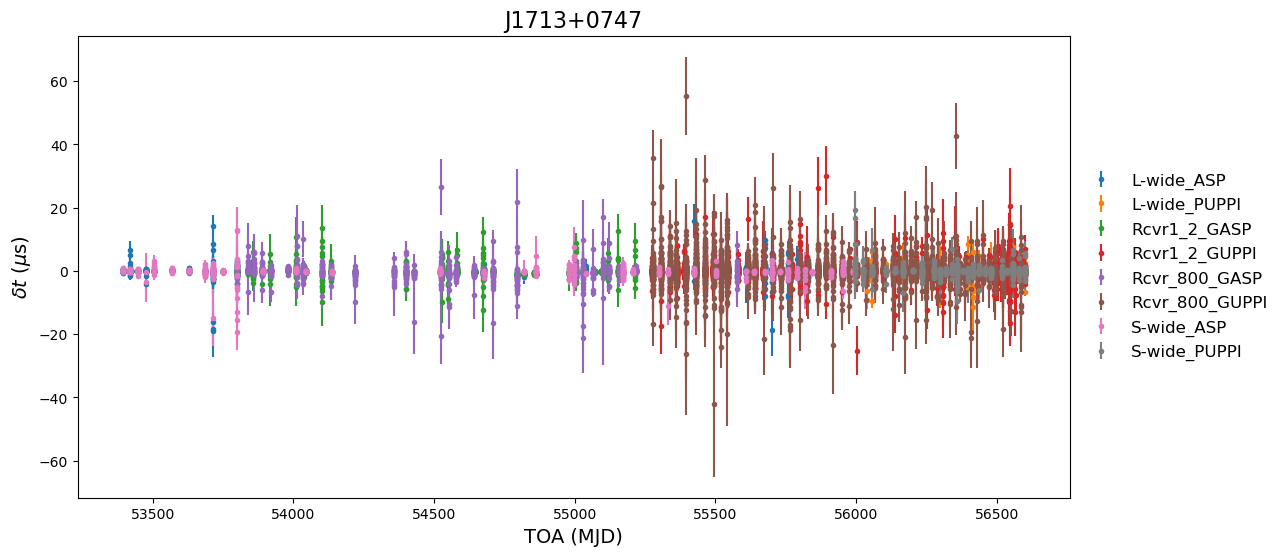

In [11]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

for bkend in np.unique(psr.flagvals('group')):
    nix = psr.flagvals('group') == bkend
    nix *= np.logical_not(psr.deletedmask())
    if np.sum(nix) > 0:
        ax.errorbar(psr.toas()[nix], psr.residuals()[nix]*1e6, psr.toaerrs[nix],
                    label=bkend, linestyle='none', marker='.')

ax.set_xlabel("TOA (MJD)", fontsize=14)
ax.set_ylabel(r"$\delta t$ ($\mu$s)", fontsize=14)

ax.legend(loc='center left', frameon=False, fontsize=12, bbox_to_anchor=(1, 0.5))

plt.title(psr.name, fontsize=16);

### Pulsar dictionary

This is input to the `make_dataset()` function.  `make_dataset()` loops over a list of pulsars and runs `filter_psr()` on each.

Ths pulsar dictionary is a dictionary of filters.  The keys are the pulsars we wish to use, and the values are the `filter_dict`s to use for that pulsar.

### Example pulsar dictionaries

We define several pulsar dictionaries that can be used to generate filtered DR2-lite datasets.

In [ ]:
# NG9 + J0437
# to exclude pre-XASP NG data, we must list all of the XASP/XUPPI backends to keep
fname = 'psrdicts/ng9+J0437.json'

psrdict = {'J1713+0747': {'pta': ['NANOGrav'], 
                          'f': ['Rcvr1_2_GASP', 'Rcvr1_2_GUPPI', 
                                 'Rcvr_800_GASP', 'Rcvr_800_GUPPI', 
                                 'L-wide_ASP', 'L-wide_PUPPI','S-wide_ASP', 
                                 'S-wide_PUPPI']},
           'J1909-3744': {'pta': ['NANOGrav']},
           'J1640+2224': {'pta': ['NANOGrav']},
           'J1600-3053': {'pta': ['NANOGrav']},
           'J2317+1439': {'pta': ['NANOGrav']},
           'J1918-0642': {'pta': ['NANOGrav']},
           'J1614-2230': {'pta': ['NANOGrav']},
           'J1744-1134': {'pta': ['NANOGrav']},
           'J0030+0451': {'pta': ['NANOGrav']},
           'J2145-0750': {'pta': ['NANOGrav']},
           'J1857+0943': {'pta': ['NANOGrav']},
           'J1853+1303': {'pta': ['NANOGrav']},
           'J0613-0200': {'pta': ['NANOGrav']},
           'J1455-3330': {'pta': ['NANOGrav']},
           'J1741+1351': {'pta': ['NANOGrav']},
           'J2010-1323': {'pta': ['NANOGrav']},
           'J1024-0719': {'pta': ['NANOGrav']},
           'J1012+5307': {'pta': ['NANOGrav']},
           'J0437-4715': {'pta': ['PPTA']},
          }

with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

In [ ]:
# NG9 + PPTA4 (combined data for the 4 pulsars)
fname = 'psrdicts/ng9+ppta4.json'

psrdict = {'J1713+0747': {'pta': ['NANOGrav', 'PPTA'], 
                          'f': ['Rcvr1_2_GASP', 'Rcvr1_2_GUPPI', 
                                'Rcvr_800_GASP', 'Rcvr_800_GUPPI', 
                                'L-wide_ASP', 'L-wide_PUPPI','S-wide_ASP', 
                                'S-wide_PUPPI', '1050CM_CPSR2', '1050CM_PDFB1', 
                                '1050CM_PDFB2', '1050CM_PDFB3',
                                '1050CM_PDFB4', '1050CM_WBCORR', 'H-OH_CPSR2m', 'H-OH_CPSR2n',
                                'H-OH_PDFB1', 'MULTI_CPSR2m', 'MULTI_CPSR2n', 'MULTI_PDFB1',
                                'MULTI_PDFB2', 'MULTI_PDFB3', 'MULTI_PDFB4', 'MULTI_WBCORR']},
           'J1909-3744': {'pta': ['NANOGrav', 'PPTA']},
           'J1640+2224': {'pta': ['NANOGrav']},
           'J1600-3053': {'pta': ['NANOGrav']},
           'J2317+1439': {'pta': ['NANOGrav']},
           'J1918-0642': {'pta': ['NANOGrav']},
           'J1614-2230': {'pta': ['NANOGrav']},
           'J1744-1134': {'pta': ['NANOGrav', 'PPTA']},
           'J0030+0451': {'pta': ['NANOGrav']},
           'J2145-0750': {'pta': ['NANOGrav']},
           'J1857+0943': {'pta': ['NANOGrav']},
           'J1853+1303': {'pta': ['NANOGrav']},
           'J0613-0200': {'pta': ['NANOGrav']},
           'J1455-3330': {'pta': ['NANOGrav']},
           'J1741+1351': {'pta': ['NANOGrav']},
           'J2010-1323': {'pta': ['NANOGrav']},
           'J1024-0719': {'pta': ['NANOGrav']},
           'J1012+5307': {'pta': ['NANOGrav']},
           'J0437-4715': {'pta': ['PPTA']},
          }

with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

In [ ]:
# NG9 with 1713, 1744, 1909, 0437 from PPTA instead of NG
fname = 'psrdicts/ng9_replace_ppta4.json'

psrdict = {'J1713+0747': {'pta': ['PPTA']},
           'J1909-3744': {'pta': ['PPTA']},
           'J1640+2224': {'pta': ['NANOGrav']},
           'J1600-3053': {'pta': ['NANOGrav']},
           'J2317+1439': {'pta': ['NANOGrav']},
           'J1918-0642': {'pta': ['NANOGrav']},
           'J1614-2230': {'pta': ['NANOGrav']},
           'J1744-1134': {'pta': ['PPTA']},
           'J0030+0451': {'pta': ['NANOGrav']},
           'J2145-0750': {'pta': ['NANOGrav']},
           'J1857+0943': {'pta': ['NANOGrav']},
           'J1853+1303': {'pta': ['NANOGrav']},
           'J0613-0200': {'pta': ['NANOGrav']},
           'J1455-3330': {'pta': ['NANOGrav']},
           'J1741+1351': {'pta': ['NANOGrav']},
           'J2010-1323': {'pta': ['NANOGrav']},
           'J1024-0719': {'pta': ['NANOGrav']},
           'J1012+5307': {'pta': ['NANOGrav']},
           'J0437-4715': {'pta': ['PPTA']},
          }

with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

In [ ]:
# PPTA 10cm data for Shannon, et al (2015)
fname = 'psrdicts/ppta4_10cm.json'

psrdict = {'J1713+0747': {'pta': ['PPTA'],'group': ['PDFB_10CM', 'WBCORR_10CM']},
           'J1909-3744': {'pta': ['PPTA'], 'group': ['PDFB_10CM', 'WBCORR_10CM']},
           'J1744-1134': {'pta': ['PPTA'], 'group': ['PDFB_10CM', 'WBCORR_10CM']},
           'J0437-4715': {'pta': ['PPTA'], 'group': ['PDFB_10CM', 'WBCORR_10CM']},
          }

with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

# 2.2) Generate DR2-lite style dataset

This generates an all EPTA `psrdict`, or make your own, or choose from above

In [ ]:
psrdict = {}  
PSRnames = glob.glob('partim/*.par')

for psrname in PSRnames:
    name = psrname.split('/')[-1].split('.')[0]
    psrdict.update({name: [{'pta':['EPTA']}]})
    
fname = 'psrdicts/epta_only.json'
with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

or load from a file

In [ ]:
dict_file = 'psrdicts/epta_only.json'
with open(dict_file, 'r') as fin:
    psrdict = json.load(fin)

In [ ]:
dr2u.make_dataset(psrdict, outdir='partim_epta')